In [1]:
import random
import pandas as pd
import numpy as np
from collections import namedtuple
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import DAILY, DateFormatter, rrulewrapper, RRuleLocator, datestr2num

### Define needed data structure

In [2]:
Measure = namedtuple('Measure', 'C1 C2, C3, C4, C5, C6, C7, C8, H1, stringency')
Tested = namedtuple('Tested', 'cumulative daily')
Confirmed = namedtuple('Confirmed', 'cumulative daily')
Combined = namedtuple('Combined', 'measure confirmed tested')

### Load the cleaned and integrated data

In [3]:
import pickle

filename = '../cleaned_integrated_data.pkl'

with open(filename, 'rb') as fp:
    loaded = pickle.load(fp)
    
print('Total number of samples: {}'.format(len(loaded)))

key = random.choice(list(loaded.keys()))
print('A random sample in the integrated dataset:')
print('key: ', key)
print('value: ', loaded[key])

Total number of samples: 3368
A random sample in the integrated dataset:
key:  (Timestamp('2020-04-02 00:00:00'), 'Slovenia')
value:  Combined(measure=Measure(C1=3.0, C2=3.0, C3=2.0, C4=4.0, C5=2.0, C6=1.0, C7=2.0, C8=3.0, H1=2.0, stringency=91.93), confirmed=Confirmed(cumulative=897, daily=56), tested=Tested(cumulative=25921, daily=1064))


In [4]:
a2m = {'C1': 'C1_School closing', 'C2': 'C2_Workplace closing', 'C3': 'C3_Cancel public events', 'C4': 'C4_Restrictions on gatherings', 
       'C5': 'C5_Close public transport', 'C6': 'C6_Stay at home requirements', 'C7': 'C7_Restrictions on internal movement', 
       'C8': 'C8_International travel controls', 'H1': 'H1_Public information campaigns'}
m2a = {v: k for k, v in a2m.items()}

### Helper functions

In [5]:
from collections import OrderedDict

def search_by_country(country, dataset):
    res_by_country = dict()
    for key, value in dataset.items():
        if country in key:
            res_by_country[key] = value

    return res_by_country

def search_by_date(date, dataset):
    res_by_date = dict()
    for key, value in dataset.items():
        if date in key:
            res_by_date[key] = value

    return res_by_date

def sort_by_date(samples):
    sorted_samples = OrderedDict(sorted(samples.items(), key=lambda t: t[0][0]))

    return sorted_samples

### Visualize government measurement over time

In [6]:
import io
import requests

# Oxford Covid-19 Government Response Tracker (OxCGRT)
oxcgrt_url = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
oxcgrt_data = requests.get(oxcgrt_url).content
oxcgrt_data = pd.read_csv(io.StringIO(oxcgrt_data.decode('utf-8')))

In [7]:
# select C1 to C8, H1 and Stringency Index

dc_measure_data = dict()
Measure = namedtuple('Measure', 'C1 C2, C3, C4, C5, C6, C7, C8, H1, stringency')
for index, row in oxcgrt_data.iterrows():
    value = []
    for abbr, measure in a2m.items():
        if np.isnan(row[measure]):
            value.append(None)
        else:
            value.append(row[measure])
    if np.isnan(row['StringencyIndexForDisplay']):
        value.append(None)
    else:
        value.append(row['StringencyIndexForDisplay'])

    key = (row['Date'], row['CountryName'])
    value = Measure(*value)
    dc_measure_data[key] = value

In [8]:
# statistics of some countries are not available
def check_name(name, name_list):
    names = name.split(' ')
    if len(names) == 1:
        if names[0] in name_list:
            return True, names[0]
    if len(names) == 2:
        if ' '.join(names) in name_list:
            return True, ' '.join(names)
    if len(names) >= 3:
        if ' '.join(names[0:2]) in name_list:
            return True, ' '.join(names[0:2])
        
    return False, None

In [9]:
def vis_gov_meas(date):
    res_by_date = search_by_date(int(date), dc_measure_data)

    # extract stringency and country to form a compact dataset
    country2stringency = dict()
    for key, value in res_by_date.items():
        if isinstance(value.stringency, float) or isinstance(value.stringency, int):
            country2stringency[key[1]] = value.stringency

    # load world map
    shapename = 'admin_0_countries'
    countries_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

    # convert from stringency to color, higher the stringency index, deeper the color
    cmap = cm.Greens
    norm = mpl.colors.Normalize(vmin=0, vmax=100)
    for key, value in country2stringency.items():
        country2stringency[key] = cmap(norm(value))[0:3]

    # set figure size
    plt.figure(figsize=(12, 16))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    name_list = list(country2stringency.keys())

    for country in shpreader.Reader(countries_shp).records():
        country_name = country.attributes['NAME']
        exist_flag, country_name = check_name(country_name, name_list)
        # country data found
        if exist_flag:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=country2stringency[country_name],
                              label=country.attributes['NAME'])
        # no data for this country
        else:
            ax.add_geometries(country.geometry, ccrs.PlateCarree(), 
                              facecolor=(1.0, 1.0, 1.0),
                              label=country.attributes['NAME'])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    plt.colorbar(sm, fraction=0.0239, pad=0.02)
    
    plt.title(date[0:4] + '-' + date[4:6] + '-' + date[6:])
    
    plt.show()

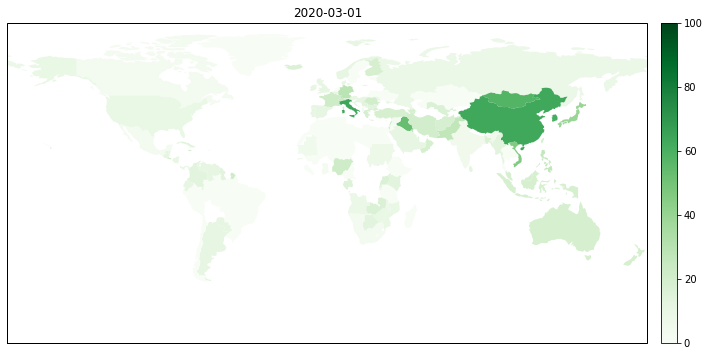

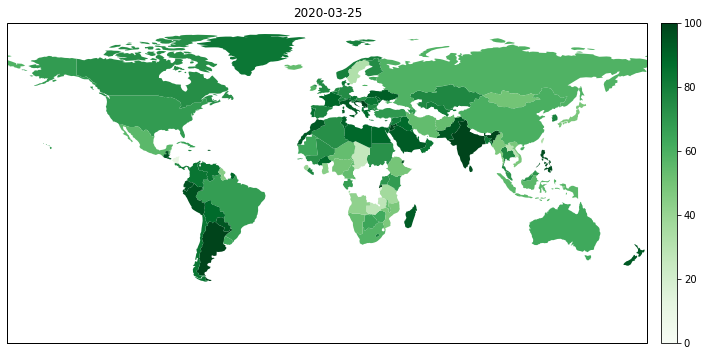

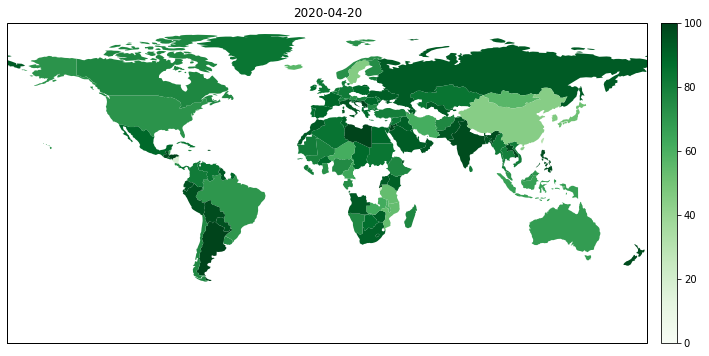

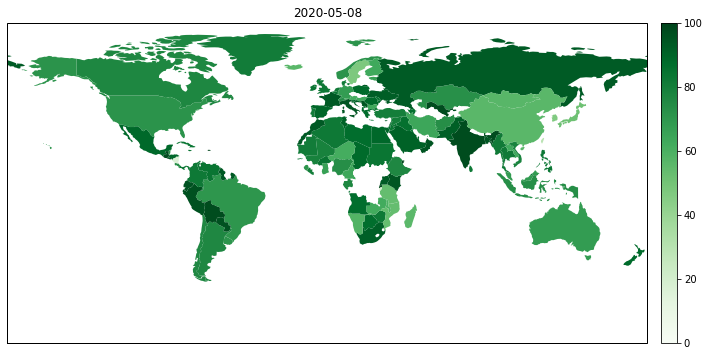

In [10]:
# ref: https://stackoverflow.com/questions/13397022/fill-countries-in-python-basemap
import itertools
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

date = '20200301'
vis_gov_meas(date)

date = '20200325'
vis_gov_meas(date)

date = '20200420'
vis_gov_meas(date)

date = '20200508'
vis_gov_meas(date)

#### Visualize the relation between a government measurement and the confirmed ratio

In [11]:
def vis_meas_over_ratio(country, measurement):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]
    dates = datestr2num(dates)

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]

    if measurement == 'stringency':
        meas_values = [value.measure.stringency for value in sorted_samples.values()]
    else:
        meas_values = [getattr(value.measure, measurement) for value in sorted_samples.values()]

    rule = rrulewrapper(DAILY, interval=10)
    loc = RRuleLocator(rule)
    formatter = DateFormatter('%Y-%m-%d')

    fig, ax1 = plt.subplots()
    ax1.plot_date(dates, confirmed_over_tested, 'r')
    ax1.set_ylabel('ratio', color='red')

    ax2 = ax1.twinx()
    ax2.plot_date(dates, meas_values, 'b')
    if measurement == 'stringency':
        ax2.set_ylabel('stringency', color='blue')
    else:
        ax2.set_ylabel(a2m[measurement], color='blue')

    ax1.xaxis.set_major_locator(loc)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.set_tick_params(rotation=30, labelsize=10)

    plt.title(country)

    plt.show()

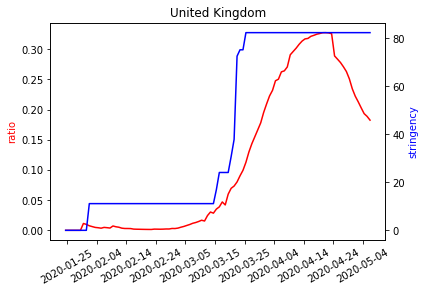

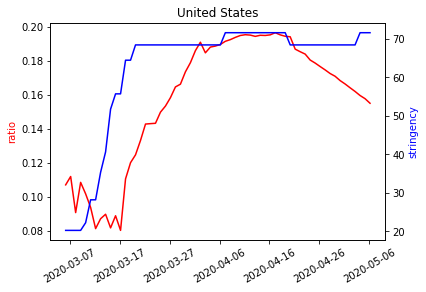

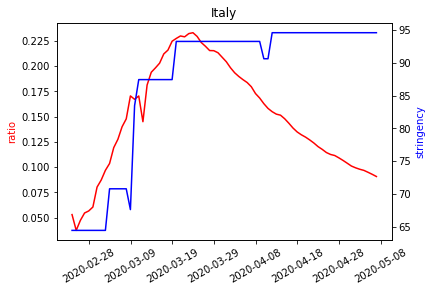

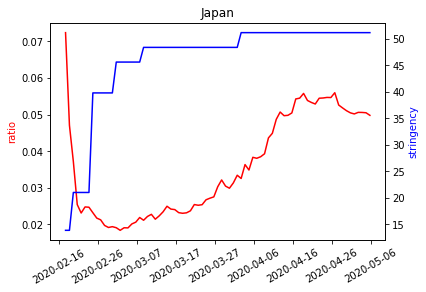

In [13]:
# select a country as an example
# ref: https://matplotlib.org/3.1.1/gallery/ticks_and_spines/date_demo_rrule.html

country = 'United Kingdom'
vis_meas_over_ratio(country, 'stringency')

country = 'United States'
vis_meas_over_ratio(country, 'stringency')

country = 'Italy'
vis_meas_over_ratio(country, 'stringency')

country = 'Japan'
vis_meas_over_ratio(country, 'stringency')

#### Auto-regression model for ratio

          t-1       t+1
t-1  1.000000  0.983072
t+1  0.983072  1.000000


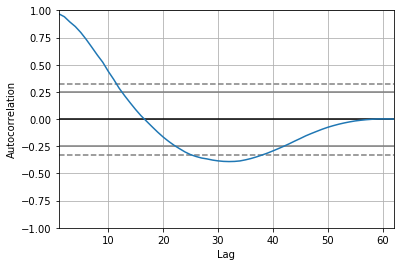

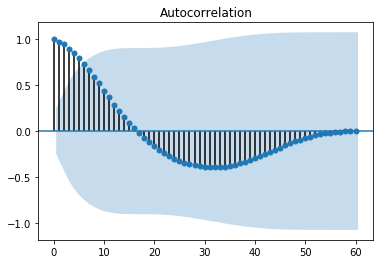

In [14]:
from pandas.plotting import lag_plot, autocorrelation_plot
import pdb

def auto_correlation_analyze(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    values = pd.DataFrame(df.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']
    result = dataframe.corr()
    print(result)
    
    autocorrelation_plot(df)
    plt.show()
    
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(df, lags=60)
    plt.show()
        
country = 'United States'       
auto_correlation_analyze(country)

Test MSE: 0.002283


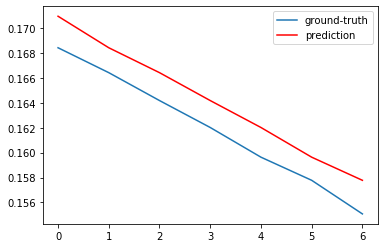

In [15]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# persistence model
def persistence_model(x):
    return x

def predict_persistent_model(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # create lagged dataset
    values = pd.DataFrame(df.values)
    dataframe = pd.concat([values.shift(1), values], axis=1)
    dataframe.columns = ['t-1', 't+1']

    # split into train and test sets
    X = dataframe.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]

    # walk-forward validation
    predictions = list()
    for x in test_X:
        yhat = persistence_model(x)
        predictions.append(yhat)

    rmse = sqrt(mean_squared_error(test_y, predictions))
    print('Test MSE: %.6f' % rmse)
    
    # plot predictions vs expected
    plt.plot(test_y, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    
    plt.legend()
    plt.show()
    
country = 'United States'       
predict_persistent_model(country)

Coefficients: [ 0.01295135  0.89878561  0.15149507  0.07531655 -0.39640079  0.29276204
 -0.12520168  0.00651031 -0.00139874  0.079417    0.06482355  0.04540669
 -0.05929419 -0.03341732  0.05372766 -0.16200259 -0.11351245  0.21912678
  0.00970442 -0.00791232 -0.07912048]
predicted=0.168936, expected=0.168421
predicted=0.166715, expected=0.166422
predicted=0.164008, expected=0.164183
predicted=0.161492, expected=0.162020
predicted=0.159628, expected=0.159637
predicted=0.157040, expected=0.157780
predicted=0.155691, expected=0.155082
Test RMSE: 0.000475


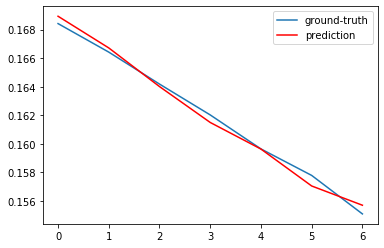

forecasted=0.168936
forecasted=0.166715
forecasted=0.164008
forecasted=0.161492
forecasted=0.159628
forecasted=0.157040
forecasted=0.155691
forecasted=0.155083
forecasted=0.153014
forecasted=0.151856
forecasted=0.150604
forecasted=0.149260
forecasted=0.148414
forecasted=0.147200
forecasted=0.146321


In [16]:
from statsmodels.tsa.ar_model import AutoReg

def predict_autoregression_model(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    # train autoregression
    model = AutoReg(train, lags=20)
    model_fit = model.fit()
    print('Coefficients: %s' % model_fit.params)
    
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))

    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.6f' % rmse)

       # plot predictions vs expected
    plt.plot(test, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    
    plt.legend()
    plt.show()

    forecasts = model_fit.predict(start=len(train) + len(test), end=len(train) + len(test) + 7)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i]))
    
country = 'United States'       
predict_autoregression_model(country)

#### Autoregressive Moving Average Model

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   54
Model:                    ARMA(20, 1)   Log Likelihood                 205.195
Method:                       css-mle   S.D. of innovations              0.005
Date:                Sat, 09 May 2020   AIC                           -364.390
Time:                        19:41:38   BIC                           -318.643
Sample:                             0   HQIC                          -346.747
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1567      0.009     17.236      0.000       0.139       0.174
ar.L1.y        1.0504      0.442      2.377      0.017       0.184       1.917
ar.L2.y        0.0823      0.418      0.197      0.8

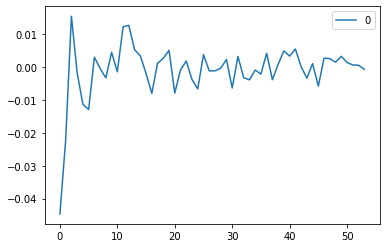

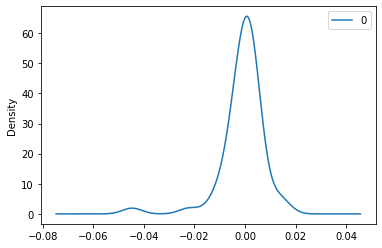

               0
count  54.000000
mean   -0.000861
std     0.008564
min    -0.044648
25%    -0.003193
50%     0.000413
75%     0.003270
max     0.015557
predicted=0.164998, expected=0.168421
predicted=0.163047, expected=0.166422
predicted=0.159114, expected=0.164183
predicted=0.152788, expected=0.162020
predicted=0.149147, expected=0.159637
predicted=0.145421, expected=0.157780
predicted=0.142733, expected=0.155082
Test RMSE: 0.008859


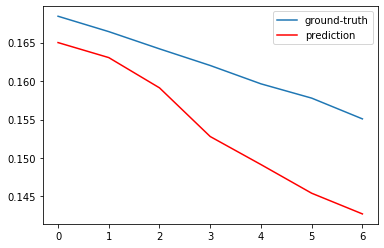

forecasted=0.164998
forecasted=0.163047
forecasted=0.159114
forecasted=0.152788
forecasted=0.149147
forecasted=0.145421
forecasted=0.142733
forecasted=0.140715
forecasted=0.138756
forecasted=0.135448
forecasted=0.134468
forecasted=0.132719
forecasted=0.129391
forecasted=0.127848
forecasted=0.125916


In [231]:
from statsmodels.tsa.arima_model import ARMA

def predict_arima_model(country):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    # fit model
    model = ARMA(train, order=(20, 1))
    model_fit = model.fit(disp=0)
    print(model_fit.summary())

    # plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    residuals.plot(kind='kde')
    plt.show()
    print(residuals.describe())
    
    # make predictions
    predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i], test[i]))

    rmse = sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test, label='ground-truth')
    plt.plot(predictions, color='red', label='prediction')
    
    plt.legend()
    plt.show()

    forecasts = model_fit.predict(start=len(train) + len(test), end=len(train) + len(test) + 7)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i]))
    
country = 'United States'       
predict_arima_model(country)

#### Vector Autoregression (VAR) model

predicted=0.172510, expected=0.168421
predicted=0.171355, expected=0.166422
predicted=0.166874, expected=0.164183
predicted=0.165255, expected=0.162020
predicted=0.163352, expected=0.159637
predicted=0.161656, expected=0.157780
predicted=0.160532, expected=0.155082
Test RMSE: 0.004093


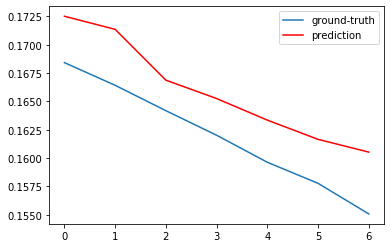

forecasted=0.160823
forecasted=0.160658
forecasted=0.157629
forecasted=0.157777
forecasted=0.157099
forecasted=0.155044
forecasted=0.151690


In [74]:
from statsmodels.tsa.vector_ar.var_model import VAR

def predict_var_model(country, measurement):
    res_by_country = search_by_country(country, loaded)
    sorted_samples = sort_by_date(res_by_country)

    dates = [key[0].strftime('%Y-%m-%d') for key in sorted_samples.keys()]

    # cumulative confirmed cases and tested cases
    cum_confirmed = [value.confirmed.cumulative for value in sorted_samples.values()]
    cum_tested = [value.tested.cumulative for value in sorted_samples.values()]

    confirmed_over_tested = [c / t for c, t in zip(cum_confirmed, cum_tested)]
    
    if measurement == 'stringency':
        meas_values = [value.measure.stringency for value in sorted_samples.values()]
    else:
        meas_values = [getattr(value.measure, measurement) for value in sorted_samples.values()]
        
    # combine into a DataFrame
    df = pd.DataFrame({'Date': dates, 'Ratio': confirmed_over_tested, 'Measurement': meas_values}).set_index('Date')
    
    # split dataset
    X = df.values
    train, test = X[1:len(X)-7], X[len(X)-7:]
    
    model = VAR(train)
    model_fit = model.fit(13)
    
    # make predictions
    predictions = model_fit.forecast(train, steps=7)

    for i in range(len(predictions)):
        print('predicted=%f, expected=%f' % (predictions[i][0], test[i][0]))
  
    rmse = sqrt(mean_squared_error(test[:, 0], predictions[:, 0]))
    print('Test RMSE: %.6f' % rmse)

    # plot predictions vs expected
    plt.plot(test[:, 0], label='ground-truth')
    plt.plot(predictions[:, 0], color='red', label='prediction')
    
    plt.legend()
    plt.show()

    forecasts = model_fit.forecast(X, steps=7)
    for i in range(len(forecasts)):
        print('forecasted=%f' % (forecasts[i][0]))
    
country = 'United States' 
measurement = 'stringency'
predict_var_model(country, measurement)